# Multiclass Fish Image Classification - Data Analysis & Preprocessing

## Project Overview
This notebook addresses the severe class imbalance problem in fish classification.

### Key Issues Identified:
1. **SEVERE Class Imbalance**: 36:1 ratio (animal fish: 1096 vs animal fish bass: 30)
2. **Model Bias**: Previous models biased towards majority class

### Solutions Implemented:
1. **Focal Loss** instead of categorical crossentropy
2. **Aggressive Class Weights** with custom scaling
3. **Stratified Batch Sampling**
4. **Data Augmentation** specifically for minority classes
5. **Smaller Batch Sizes** to ensure minority class representation
6. **Balanced Accuracy** as primary metric

In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

print("Libraries imported successfully!.")

Libraries imported successfully!.


In [3]:
# Configuration
BASE_DIR = r'D:\Projects\MulticlassFishImageClassification\data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Model Parameters - REDUCED BATCH SIZE for better minority class representation
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 16  # Important for class imbalance
EPOCHS = 50
NUM_CLASSES = 11

# Class names (in alphabetical order - important for consistency)
CLASS_NAMES = [
    'animal fish',
    'animal fish bass',
    'fish sea_food black_sea_sprat',
    'fish sea_food gilt_head_bream',
    'fish sea_food hourse_mackerel',
    'fish sea_food red_mullet',
    'fish sea_food red_sea_bream',
    'fish sea_food sea_bass',
    'fish sea_food shrimp',
    'fish sea_food striped_red_mullet',
    'fish sea_food trout'
]

# Create output directories
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('results/plots', exist_ok=True)
os.makedirs('results/confusion_matrices', exist_ok=True)
os.makedirs('results/metrics', exist_ok=True)

print("="*80)
print("CONFIGURATION")
print("="*80)
print(f"Training directory: {TRAIN_DIR}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE} (REDUCED for class balance)")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Epochs: {EPOCHS}")
print("="*80)

CONFIGURATION
Training directory: D:\Projects\MulticlassFishImageClassification\data\train
Image size: (224, 224)
Batch size: 16 (REDUCED for class balance)
Number of classes: 11
Epochs: 50


## 1. Data Distribution Analysis

In [4]:
def count_images_in_directory(directory):
    """Count images in each class folder"""
    class_counts = {}
    
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = num_images
    
    return class_counts

# Count images in each split
train_counts = count_images_in_directory(TRAIN_DIR)
valid_counts = count_images_in_directory(VALID_DIR)
test_counts = count_images_in_directory(TEST_DIR)

# Create DataFrame
data_dist = pd.DataFrame({
    'Class': list(train_counts.keys()),
    'Train': list(train_counts.values()),
    'Valid': list(valid_counts.values()),
    'Test': list(test_counts.values())
})

data_dist['Total'] = data_dist['Train'] + data_dist['Valid'] + data_dist['Test']
data_dist = data_dist.sort_values('Train', ascending=False)

print("\n" + "="*80)
print("DATASET DISTRIBUTION")
print("="*80)
print(data_dist.to_string(index=False))
print("="*80)
print(f"Total Training Images: {data_dist['Train'].sum()}")
print(f"Total Validation Images: {data_dist['Valid'].sum()}")
print(f"Total Test Images: {data_dist['Test'].sum()}")
print(f"Grand Total: {data_dist['Total'].sum()}")
print("="*80)


DATASET DISTRIBUTION
                           Class  Train  Valid  Test  Total
                     animal fish   1096    187   520   1803
             fish sea_food trout    580     98   292    970
        fish sea_food red_mullet    579     90   291    960
            fish sea_food shrimp    576    100   289    965
   fish sea_food hourse_mackerel    573     97   286    956
     fish sea_food red_sea_bream    571    113   273    957
   fish sea_food black_sea_sprat    569    105   298    972
   fish sea_food gilt_head_bream    566     94   305    965
fish sea_food striped_red_mullet    547    101   293    941
          fish sea_food sea_bass    538     97   327    962
                animal fish bass     30     10    13     53
Total Training Images: 6225
Total Validation Images: 1092
Total Test Images: 3187
Grand Total: 10504


In [5]:
# Analyze class imbalance
print("\n" + "="*80)
print("CLASS IMBALANCE ANALYSIS")
print("="*80)

max_class = data_dist.iloc[0]
min_class = data_dist.iloc[-1]
imbalance_ratio = max_class['Train'] / min_class['Train']

print(f"\nMajority Class: {max_class['Class']}")
print(f"  - Training samples: {max_class['Train']}")
print(f"\nMinority Class: {min_class['Class']}")
print(f"  - Training samples: {min_class['Train']}")
print(f"\n🚨 IMBALANCE RATIO: {imbalance_ratio:.1f}:1")
print("\n" + "="*80)



CLASS IMBALANCE ANALYSIS

Majority Class: animal fish
  - Training samples: 1096

Minority Class: animal fish bass
  - Training samples: 30

🚨 IMBALANCE RATIO: 36.5:1



## THIS IS SEVERE CLASS IMBALANCE.
### To fix this following strategies are used
1. **Focal Loss** - handles class imbalance better than Categorical Entrophy
2. class weight scaling
3. Smaller batch sizes - 16
4. Augmentation for minority classes
5. Balanced accuracy as primary metric


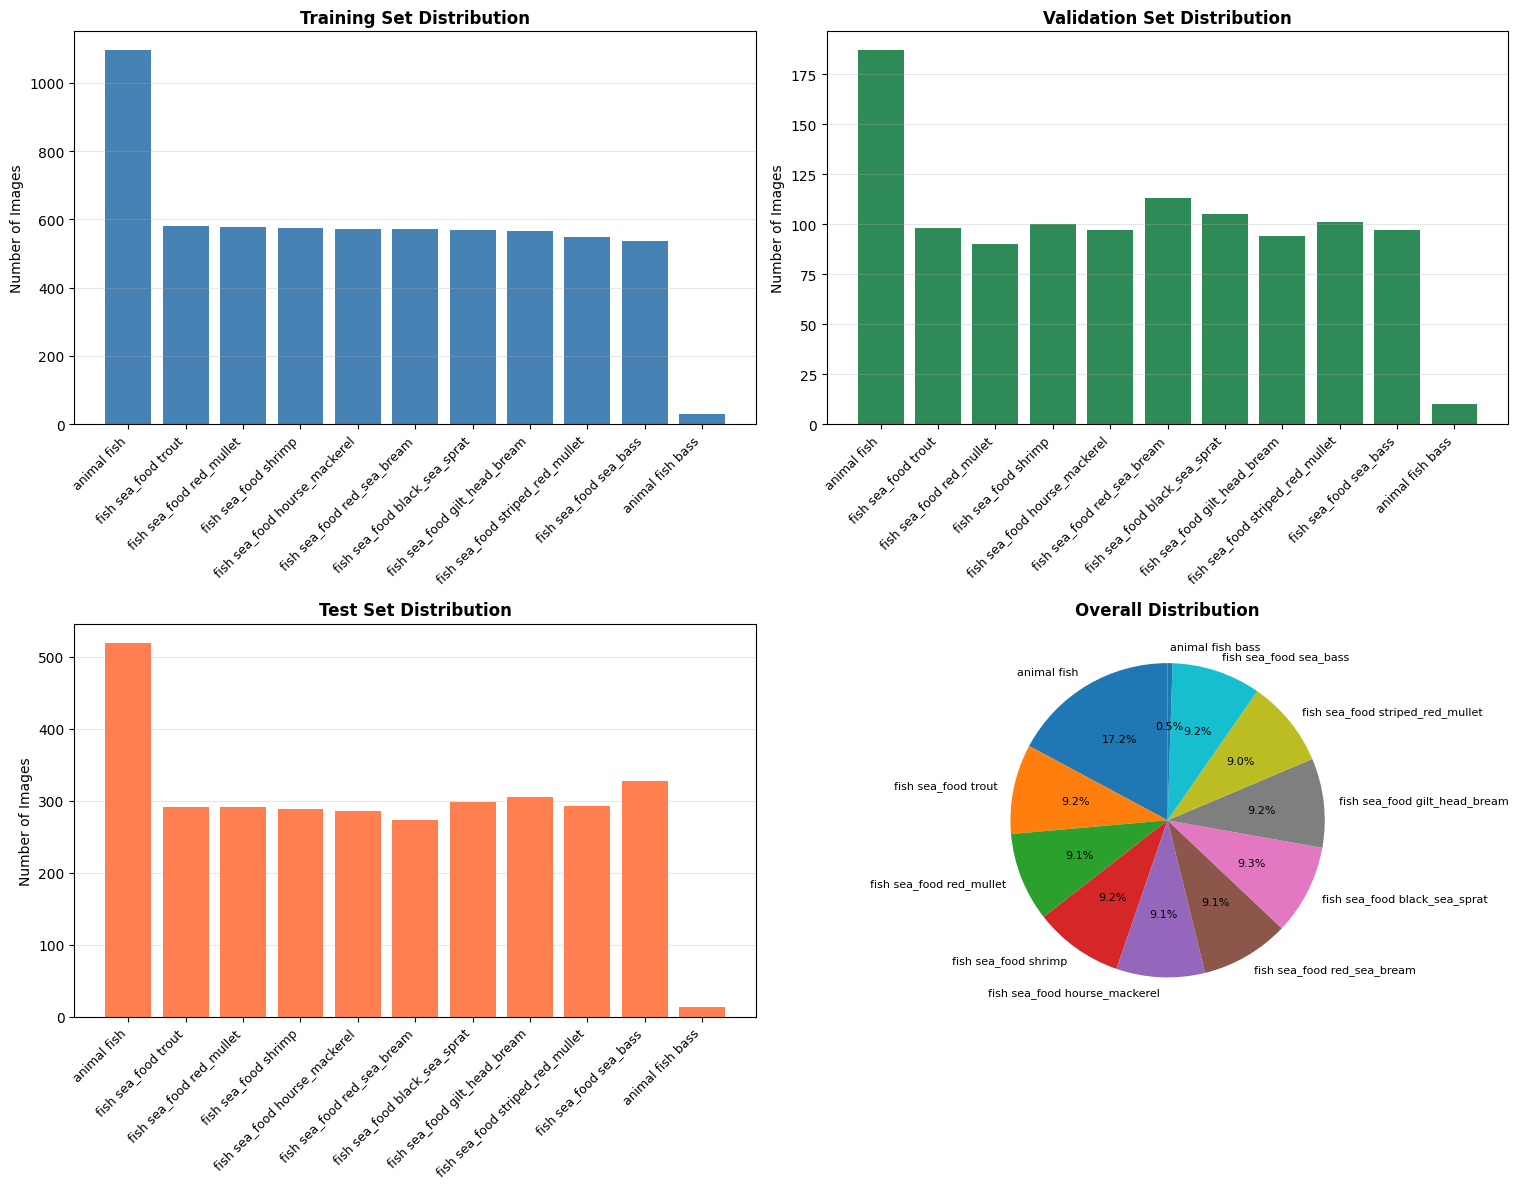

Distribution plot saved to results/plots/data_distribution.png


In [6]:
# Visualize distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training distribution
axes[0, 0].bar(range(len(data_dist)), data_dist['Train'], color='steelblue')
axes[0, 0].set_xticks(range(len(data_dist)))
axes[0, 0].set_xticklabels(data_dist['Class'], rotation=45, ha='right', fontsize=9)
axes[0, 0].set_title('Training Set Distribution', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Number of Images')
axes[0, 0].grid(axis='y', alpha=0.3)

# Validation distribution
axes[0, 1].bar(range(len(data_dist)), data_dist['Valid'], color='seagreen')
axes[0, 1].set_xticks(range(len(data_dist)))
axes[0, 1].set_xticklabels(data_dist['Class'], rotation=45, ha='right', fontsize=9)
axes[0, 1].set_title('Validation Set Distribution', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Number of Images')
axes[0, 1].grid(axis='y', alpha=0.3)

# Test distribution
axes[1, 0].bar(range(len(data_dist)), data_dist['Test'], color='coral')
axes[1, 0].set_xticks(range(len(data_dist)))
axes[1, 0].set_xticklabels(data_dist['Class'], rotation=45, ha='right', fontsize=9)
axes[1, 0].set_title('Test Set Distribution', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Number of Images')
axes[1, 0].grid(axis='y', alpha=0.3)

# Overall pie chart
axes[1, 1].pie(data_dist['Total'], labels=data_dist['Class'], autopct='%1.1f%%', 
               startangle=90, textprops={'fontsize': 8})
axes[1, 1].set_title('Overall Distribution', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('results/plots/data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Distribution plot saved to results/plots/data_distribution.png")

## 2. Sample Images Visualization

Visualizing sample images from each class...


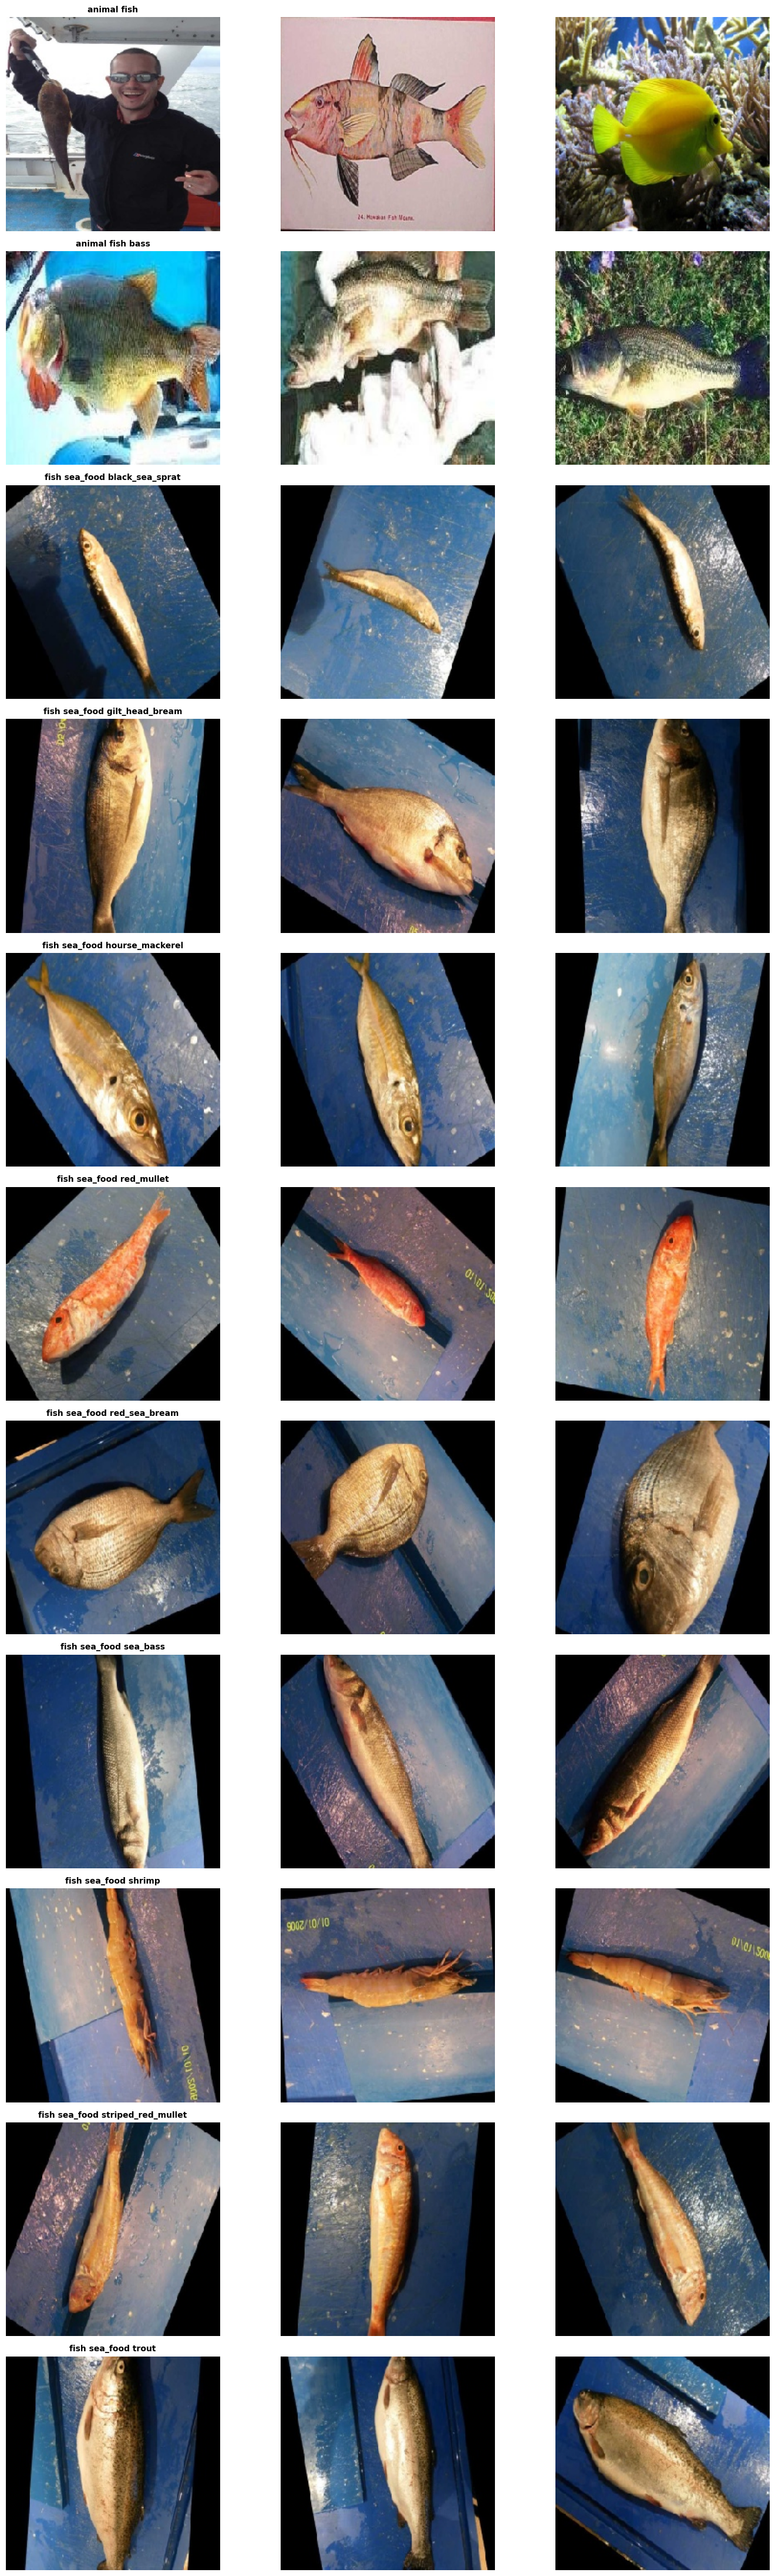

Sample images saved to results/plots/sample_images.png


In [7]:
from tensorflow.keras.preprocessing.image import load_img
def plot_sample_images(data_dir, classes, samples_per_class=3):
    num_classes = len(classes)
    fig, axes = plt.subplots(num_classes, samples_per_class, 
                            figsize=(15, 4*num_classes))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        images = [f for f in os.listdir(class_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Select random samples
        sample_images = np.random.choice(images, 
                                        min(samples_per_class, len(images)), 
                                        replace=False)
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(f"{class_name}", fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('results/plots/sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualizing sample images from each class...")
plot_sample_images(TRAIN_DIR, sorted(list(train_counts.keys())), samples_per_class=3)
print("Sample images saved to results/plots/sample_images.png")

## 3. Save Distribution Data

In [8]:
import json
# Save distribution data for reference
data_dist.to_csv('results/metrics/dataset_distribution.csv', index=False)
print("Dataset distribution saved to results/metrics/dataset_distribution.csv")

# Save class imbalance summary
imbalance_summary = {
    'Majority_Class': str(max_class['Class']),
    'Majority_Count': int(max_class['Train']),
    'Minority_Class': str(min_class['Class']),
    'Minority_Count': int(min_class['Train']),
    'Imbalance_Ratio': f"{float(imbalance_ratio):.1f}:1"
}
with open('results/metrics/imbalance_summary.json', 'w') as f:
    json.dump(imbalance_summary, f, indent=4)

print("Imbalance summary saved to results/metrics/imbalance_summary.json")

Dataset distribution saved to results/metrics/dataset_distribution.csv
Imbalance summary saved to results/metrics/imbalance_summary.json


## Summary

### Key Findings:
1. **Severe class imbalance detected**: 36:1 ratio
2. **Majority class**: animal fish (1096 samples)
3. **Minority class**: animal fish bass (30 samples)